<a href="https://colab.research.google.com/github/miguelayllon/MasterIA_DeepLearning/blob/main/clasificacion_imagenes_transfer_learning_CNN_Miguel_Ayllon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>

## **Mejorando modelo de clasificación  de imagenes a traves de Transfer Learning (uso red VGG16 previamente entrenada)**

Se utilizara la red convolucional VGG16 para estraer caracterísiticas para nuestras imagenes de perros , gatos y animales salvajes.

Esta red es aplicada sobre el problema de clasificación desarrollado en el programa **clasificacion imagenes basico CNN Miguel_Ayllon.ipynb**

In [1]:
# Basado en parte de:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [2]:
COLAB = True

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import keras
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

Si se desea ejecutar en local:

- Descargar el dataset de: https://drive.google.com/file/d/1kCpxp2qY5YhNZW4d43yPw8TloqQVTzaq/view?usp=sharing


- Poner variable COLAB a False

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
COLAB = True

# Obtenemos la información del dataset animals.zip 
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1kCpxp2qY5YhNZW4d43yPw8TloqQVTzaq',
                                        dest_path='./animals.zip', unzip=True)

Unzipping...Done.


In [7]:
# Definimos las fuentes de data
train_dir      = 'animals/train'
validation_dir = 'animals/val'
test_dir       = 'animals/test'

number_train_samples = 10920
number_val_samples   = 3120
number_test_samples  = 1560

number_train_samples, number_val_samples, number_test_samples

(10920, 3120, 1560)

**Definimos la función extract_features(directory, sample_count)**

In [8]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))

    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='sparse')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [9]:
# Obtenemos las caracteristicas para train, validation y test
train_features, train_labels           = extract_features(train_dir, number_train_samples)
validation_features, validation_labels = extract_features(validation_dir, number_val_samples)
test_features, test_labels             = extract_features(test_dir, number_test_samples)

Found 10920 images belonging to 3 classes.
Found 3120 images belonging to 3 classes.
Found 1560 images belonging to 3 classes.


In [10]:
train_features.shape,validation_features.shape,test_features.shape

((10920, 4, 4, 512), (3120, 4, 4, 512), (1560, 4, 4, 512))

**Flatten**

---
Las características extraídas están actualmente con el formato (muestras, 4, 4, 512). Pero necesitamos aplanarlos **(flatten)** a una estructura (samples, 8192) para  alimentar a un clasificador densamente conectado.

In [11]:
# Redefinimos los tamaños train_features,validation_features y test_features
train_features      = np.reshape(train_features, (number_train_samples, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (number_val_samples, 4 * 4 * 512))
test_features       = np.reshape(test_features, (number_test_samples, 4 * 4 * 512))

In [12]:
train_features.shape, validation_features.shape,test_features.shape

((10920, 8192), (3120, 8192), (1560, 8192))

En este punto, podemos definir nuestro clasificador densamente conectado y entrenarlo en los datos y etiquetas que acabamos de obtener.
Utlizamos el Dropout para temas de regularización.

In [13]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512)) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [16]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
683/683 [==============================] - 3s 4ms/step - loss: 0.5705 - acc: 0.7650 - val_loss: 0.0822 - val_acc: 0.9724
Epoch 2/30
683/683 [==============================] - 2s 3ms/step - loss: 0.1069 - acc: 0.9661 - val_loss: 0.0566 - val_acc: 0.9798
Epoch 3/30
683/683 [==============================] - 2s 3ms/step - loss: 0.0733 - acc: 0.9729 - val_loss: 0.0481 - val_acc: 0.9821
Epoch 4/30
683/683 [==============================] - 2s 3ms/step - loss: 0.0609 - acc: 0.9792 - val_loss: 0.0432 - val_acc: 0.9833
Epoch 5/30
683/683 [==============================] - 2s 3ms/step - loss: 0.0538 - acc: 0.9785 - val_loss: 0.0452 - val_acc: 0.9827
Epoch 6/30
683/683 [==============================] - 2s 3ms/step - loss: 0.0447 - acc: 0.9851 - val_loss: 0.0393 - val_acc: 0.9853
Epoch 7/30
683/683 [==============================] - 2s 3ms/step - loss: 0.0414 - acc: 0.9843 - val_loss: 0.0382 - val_acc: 0.9856
Epoch 8/30
683/683 [==============================] - 2s 3ms/step - loss: 0.

El entrenamiento es muy rápido, ya que solo tenemos que lidiar con dos capas "densas".
Echemos un vistazo a las curvas de pérdida y precisión durante el entrenamiento:

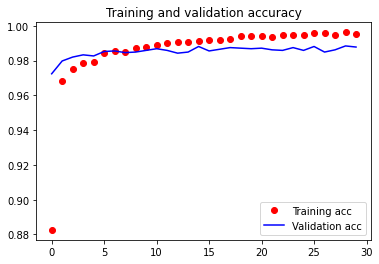

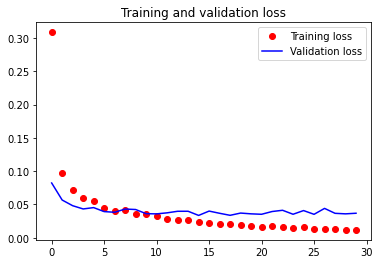

In [17]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs  = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Método 2 - Extendiendo el Modelo**

---

Extendiendo el modelo que tenemos **('conv_base')** agregamos capas 'Dense' en la parte superior y ejecutando todo la red. De un extremo a otro con los datos de entrada. Nos apoyamos del data aumentation para mejorar el aprendizaje.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

Así es como se ve nuestro modelo ahora:


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('Este es el número de pesos entrenables ' 
      'antes de hacer freezing a la conv base:', len(model.trainable_weights))

Este es el número de pesos entrenables antes de hacer freezing a la conv base: 30


In [ ]:
# Se hace frezing a la red 'conv base'
conv_base.trainable = False

In [ ]:
print('Este es el número de pesos entrenables ' 
      'despues de hacer freezing a la conv base:', len(model.trainable_weights))

Este es el número de pesos entrenables despues de hacer freezing a la conv base: 4


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='sparse')

Found 10920 images belonging to 3 classes.
Found 3120 images belonging to 3 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 - 19s - loss: 0.7917 - acc: 0.6706 - val_loss: 0.3812 - val_acc: 0.9187
Epoch 2/30
100/100 - 18s - loss: 0.4371 - acc: 0.8681 - val_loss: 0.2066 - val_acc: 0.9400
Epoch 3/30
100/100 - 18s - loss: 0.3404 - acc: 0.9000 - val_loss: 0.1927 - val_acc: 0.9362
Epoch 4/30
100/100 - 18s - loss: 0.2859 - acc: 0.9087 - val_loss: 0.1596 - val_acc: 0.9450
Epoch 5/30
100/100 - 18s - loss: 0.2500 - acc: 0.9156 - val_loss: 0.1121 - val_acc: 0.9663
Epoch 6/30
100/100 - 18s - loss: 0.2418 - acc: 0.9250 - val_loss: 0.0835 - val_acc: 0.9750
Epoch 7/30
100/100 - 18s - loss: 0.2037 - acc: 0.9300 - val_loss: 0.0817 - val_acc: 0.9700
Epoch 8/30
100/100 - 18s - loss: 0.2231 - acc: 0.9206 - val_loss: 0.0869 - val_acc: 0.9650
Epoch 9/30
100/100 - 18s - loss: 0.1843 - acc: 0.9344 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 10/30
100/100 - 18s - loss: 0.1849 - acc: 0.9394 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 11/30
100/100 - 18s - loss: 0.1757 - acc: 0.9325 - val_loss: 0.0895 - val_acc: 0.96

In [ ]:
model.save('animals_model_pretained_best_2.h5')

In [ ]:
!ls -la

total 762568
drwxr-xr-x 1 root root      4096 Mar  1 04:46 .
drwxr-xr-x 1 root root      4096 Mar  1 04:25 ..
drwxr-xr-x 5 root root      4096 Mar  1 04:33 animals
-rw-r--r-- 1 root root  75710760 Mar  1 04:46 animals_model_pretained_best_2.h5
-rw-r--r-- 1 root root 705126532 Mar  1 04:33 animals.zip
drwxr-xr-x 4 root root      4096 Feb 24 17:48 .config
drwxr-xr-x 1 root root      4096 Feb 24 17:49 sample_data


Tracemos nuestros resultados de nuevo

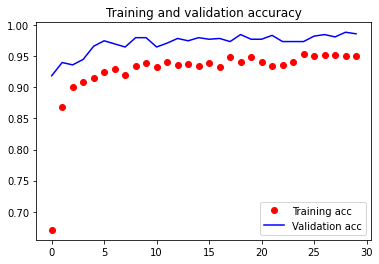

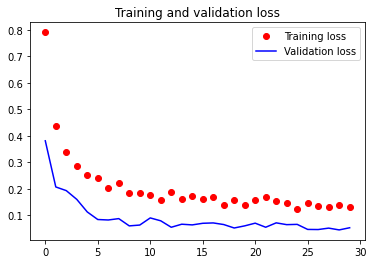

In [ ]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Como puede ver, alcanzamos una precisión de validación de aproximadamente el 98%. Esto es mucho mejor que nuestro convnet de animales entrenado desde cero.

**Método 3 - Fine-tuning**
---

Afinando el tuneo de la red

Por lo tanto, los pasos para ajustar una red son los siguientes:

* 1) Agregue su red personalizada sobre una red base ya entrenada.
* 2) Congelar la red base.
* 3) Entrena la parte que agregaste.
* 4) Descongele algunas capas en la red base.
* 5) Entrene conjuntamente ambas capas y la parte que agregó.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# Se descogela la red conv_base
conv_base.trainable = True

# Se descongela solo las capas de la red conv_base del bloque 5 
# de redes convolucionales. Las demas redes se dejan congeladas.
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

**Información del modelo final tuneado**

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 9,177,603
Non-trainable params: 7,635,264
_________________________________________________________________


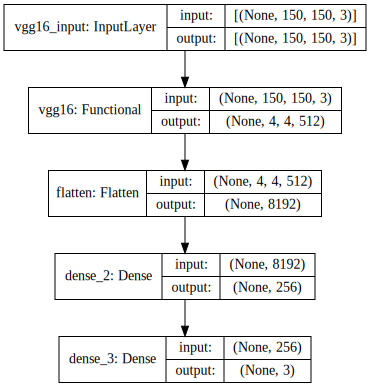

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,      
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
100/100 [==============================] - 20s 186ms/step - loss: 0.1890 - acc: 0.9309 - val_loss: 0.0550 - val_acc: 0.9812
Epoch 2/50
100/100 [==============================] - 18s 185ms/step - loss: 0.1266 - acc: 0.9557 - val_loss: 0.0411 - val_acc: 0.9850
Epoch 3/50
100/100 [==============================] - 18s 184ms/step - loss: 0.1040 - acc: 0.9632 - val_loss: 0.0450 - val_acc: 0.9812
Epoch 4/50
100/100 [==============================] - 18s 183ms/step - loss: 0.1073 - acc: 0.9568 - val_loss: 0.0406 - val_acc: 0.9875
Epoch 5/50
100/100 [==============================] - 18s 184ms/step - loss: 0.1025 - acc: 0.9553 - val_loss: 0.0366 - val_acc: 0.9900
Epoch 6/50
100/100 [==============================] - 18s 185ms/step - loss: 0.0930 - acc: 0.9684 - val_loss: 0.0344 - val_acc: 0.9887
Epoch 7/50
100/100 [==============================] - 18s 184ms/step - loss: 0.0831 - acc: 0.9688 - val_loss: 0.0297 - val_acc: 0.9887
Epoch 8/50
100/100 [==============================] - 1

In [ ]:
model.save('animals_model_pretained_best_3.h5')

In [ ]:
!ls -la

total 864172
drwxr-xr-x 1 root root      4096 Mar  1 05:01 .
drwxr-xr-x 1 root root      4096 Mar  1 04:25 ..
drwxr-xr-x 5 root root      4096 Mar  1 04:33 animals
-rw-r--r-- 1 root root  75710760 Mar  1 04:46 animals_model_pretained_best_2.h5
-rw-r--r-- 1 root root 104038632 Mar  1 05:01 animals_model_pretained_best_3.h5
-rw-r--r-- 1 root root 705126532 Mar  1 04:33 animals.zip
drwxr-xr-x 4 root root      4096 Feb 24 17:48 .config
drwxr-xr-x 1 root root      4096 Feb 24 17:49 sample_data


Tracemos nuestros resultados usando el mismo código utilizado antes:

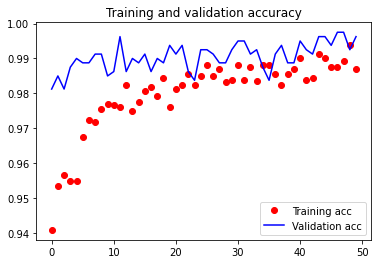

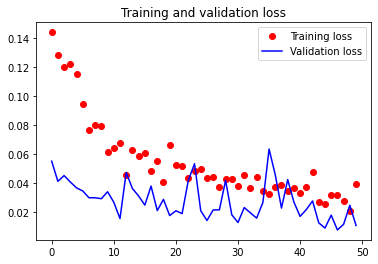

In [ ]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Estas curvas parecen muy ruidosas. Para hacerlos más legibles, podemos suavizarlos reemplazando cada pérdida y precisión con movimiento exponencial
promedios de estas cantidades. Aquí hay una función de utilidad trivial para hacer esto:

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


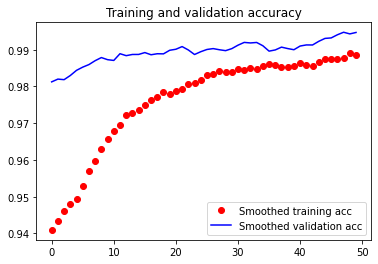

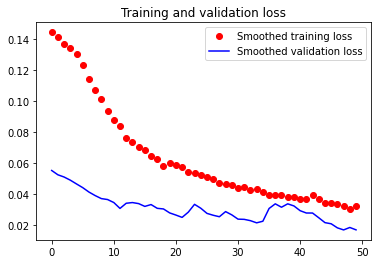

In [ ]:
plt.plot(epochs, smooth_curve(acc), 'ro', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'ro', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='sparse')

Found 1560 images belonging to 3 classes.


In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9962499737739563


## **Resultados obtenidos**

### Resultados según keras cargando los datasets en lotes:

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

683/683 [==============================] - 99s 146ms/step - loss: 0.0273 - acc: 0.9901
Train loss    : 0.02725999802350998
Train accuracy: 0.9901098608970642

195/195 [==============================] - 15s 75ms/step - loss: 0.0213 - acc: 0.9946
Val loss    : 0.02131221629679203
Val accuracy: 0.9945513010025024

98/98 [==============================] - 7s 75ms/step - loss: 0.0379 - acc: 0.9955
Test loss     : 0.03793894872069359
Test accuracy : 0.995512843132019


In [ ]:
test_generator.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(rescale=1./255)

test_generator2 = test_datagen2.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=number_test_samples,
        class_mode='sparse')

Found 1560 images belonging to 3 classes.


In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [ ]:
X_te.shape

(1560, 150, 150, 3)

In [ ]:
class_indices = test_generator2.class_indices
class_indices

{'cat': 0, 'dog': 1, 'wild': 2}

In [ ]:
 ind_cat  = np.where(y_te==class_indices["cat"])[0]
 ind_dog  = np.where(y_te==class_indices["dog"])[0]
 ind_wild = np.where(y_te==class_indices["wild"])[0]
 
 ind_cat.shape, ind_dog.shape,ind_wild.shape

((520,), (520,), (520,))

In [ ]:
def show_image(ind_te1):
  image = X_te[ind_te1].copy()
  plt.imshow(image, cmap='jet')
  plt.axis("off")

  plt.show()
  
  p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["cat"]]
  print("Probabilidad gato : {:2.1f}%".format(100*p))
  
  p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["dog"]]
  print("Probabilidad perro: {:2.1f}%".format(100*p))
  
  p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["wild"]]
  print("Probabilidad salvaje: {:2.1f}%".format(100*p))
  print("\n")

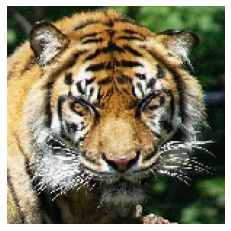

Probabilidad gato : 0.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 100.0%




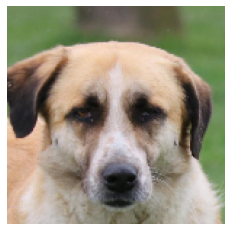

Probabilidad gato : 0.0%
Probabilidad perro: 100.0%
Probabilidad salvaje: 0.0%




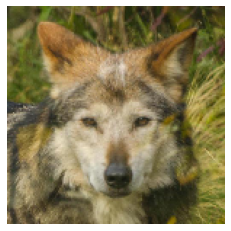

Probabilidad gato : 0.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 100.0%




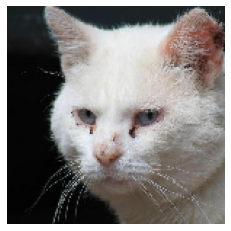

Probabilidad gato : 100.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 0.0%




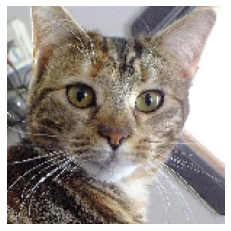

Probabilidad gato : 100.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 0.0%




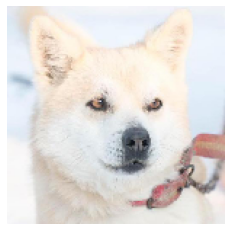

Probabilidad gato : 0.0%
Probabilidad perro: 100.0%
Probabilidad salvaje: 0.0%




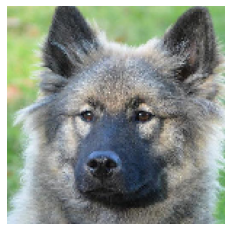

Probabilidad gato : 0.0%
Probabilidad perro: 99.1%
Probabilidad salvaje: 0.9%




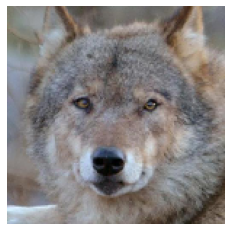

Probabilidad gato : 0.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 100.0%




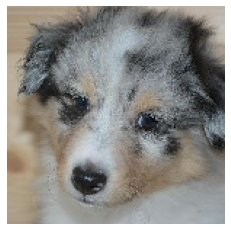

Probabilidad gato : 0.0%
Probabilidad perro: 98.8%
Probabilidad salvaje: 1.2%




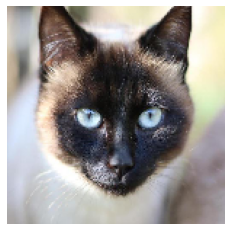

Probabilidad gato : 100.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 0.0%




In [ ]:
# Escogemos algunos valores de las 1560 imagenes para test
ind_te1 = 117

for i in range(ind_te1, ind_te1 + 10):
  show_image (i)

## **Visualización del funcionamiento de la red**

In [ ]:
weights = model.get_weights()
print(np.shape(weights))

for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(30,)
shape of weights[0]:  (3, 3, 3, 64)
shape of weights[1]:  (64,)
shape of weights[2]:  (3, 3, 64, 64)
shape of weights[3]:  (64,)
shape of weights[4]:  (3, 3, 64, 128)
shape of weights[5]:  (128,)
shape of weights[6]:  (3, 3, 128, 128)
shape of weights[7]:  (128,)
shape of weights[8]:  (3, 3, 128, 256)
shape of weights[9]:  (256,)
shape of weights[10]:  (3, 3, 256, 256)
shape of weights[11]:  (256,)
shape of weights[12]:  (3, 3, 256, 256)
shape of weights[13]:  (256,)
shape of weights[14]:  (3, 3, 256, 512)
shape of weights[15]:  (512,)
shape of weights[16]:  (3, 3, 512, 512)
shape of weights[17]:  (512,)
shape of weights[18]:  (3, 3, 512, 512)
shape of weights[19]:  (512,)
shape of weights[20]:  (3, 3, 512, 512)
shape of weights[21]:  (512,)
shape of weights[22]:  (3, 3, 512, 512)
shape of weights[23]:  (512,)
shape of weights[24]:  (3, 3, 512, 512)
shape of weights[25]:  (512,)
shape of weights[26]:  (8192, 256)
shape of weights[27]:  (256,)
shape of weights[28]:  (256, 3)
shape

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


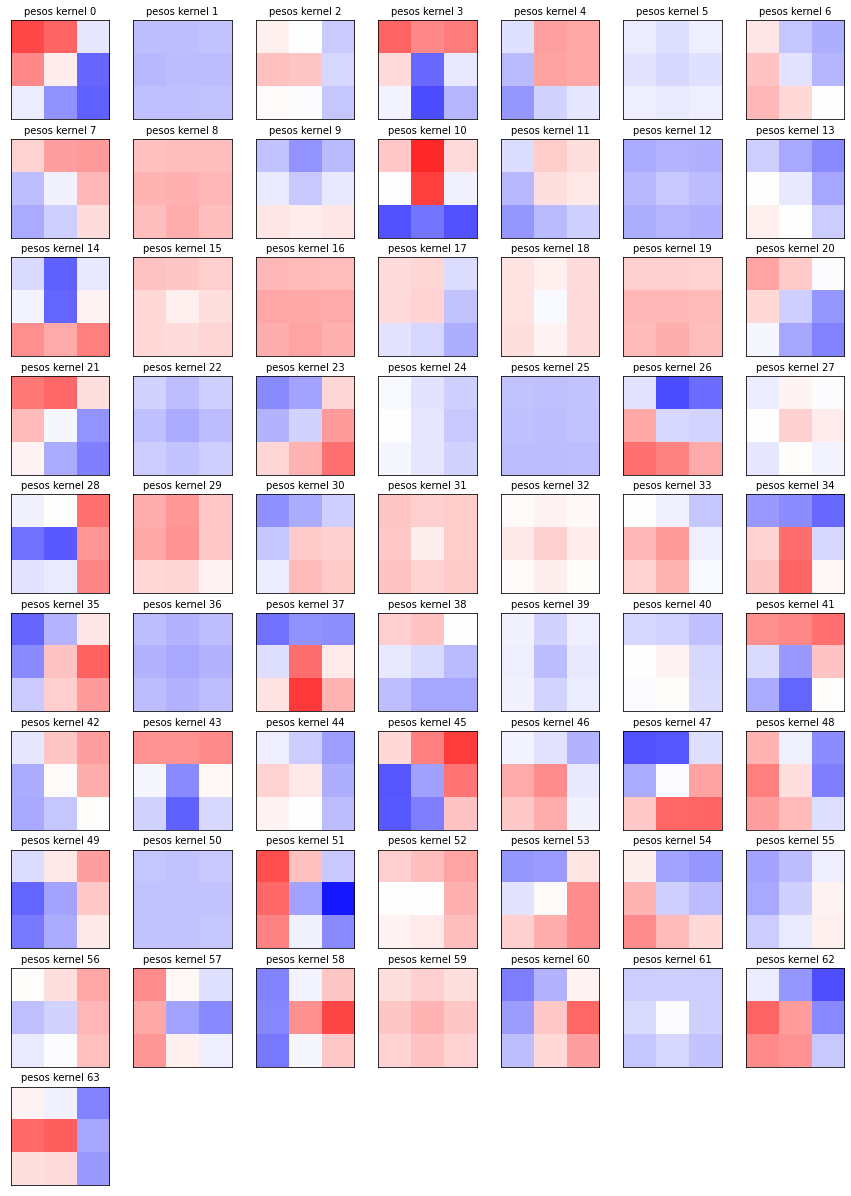

In [ ]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
ncols = 7 # número de columnas en la figura

ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()

for i in range(nfilters):
    kernel = weights[ncapa][:,:,2,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)

for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

### **Visualización de las salidas de una sola capa**

In [ ]:
# from keras.models import Sequential, load_model, Model

# # salida de una sola capa
# ncapa = 1
# intermediate_layer_model = Model(inputs=model.input,outputs=model.layers[ncapa].output)
# intermediate_layer_model.summary()

# print("\n\n")

# if COLAB:
#     display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
# else:
#     display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________





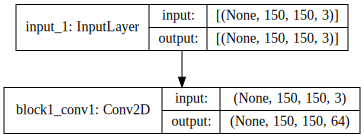

In [ ]:
from keras.models import Sequential, load_model, Model

# salida de una sola capa
ncapa = 1
intermediate_layer_model = Model(inputs=conv_base.input,outputs=conv_base.layers[ncapa].output)
intermediate_layer_model.summary()

print("\n\n")

if COLAB:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
imagen = X_te[1005]
imagen.shape

(150, 150, 3)

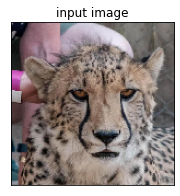

Salidas capa block1_conv1 (1, 150, 150, 64)


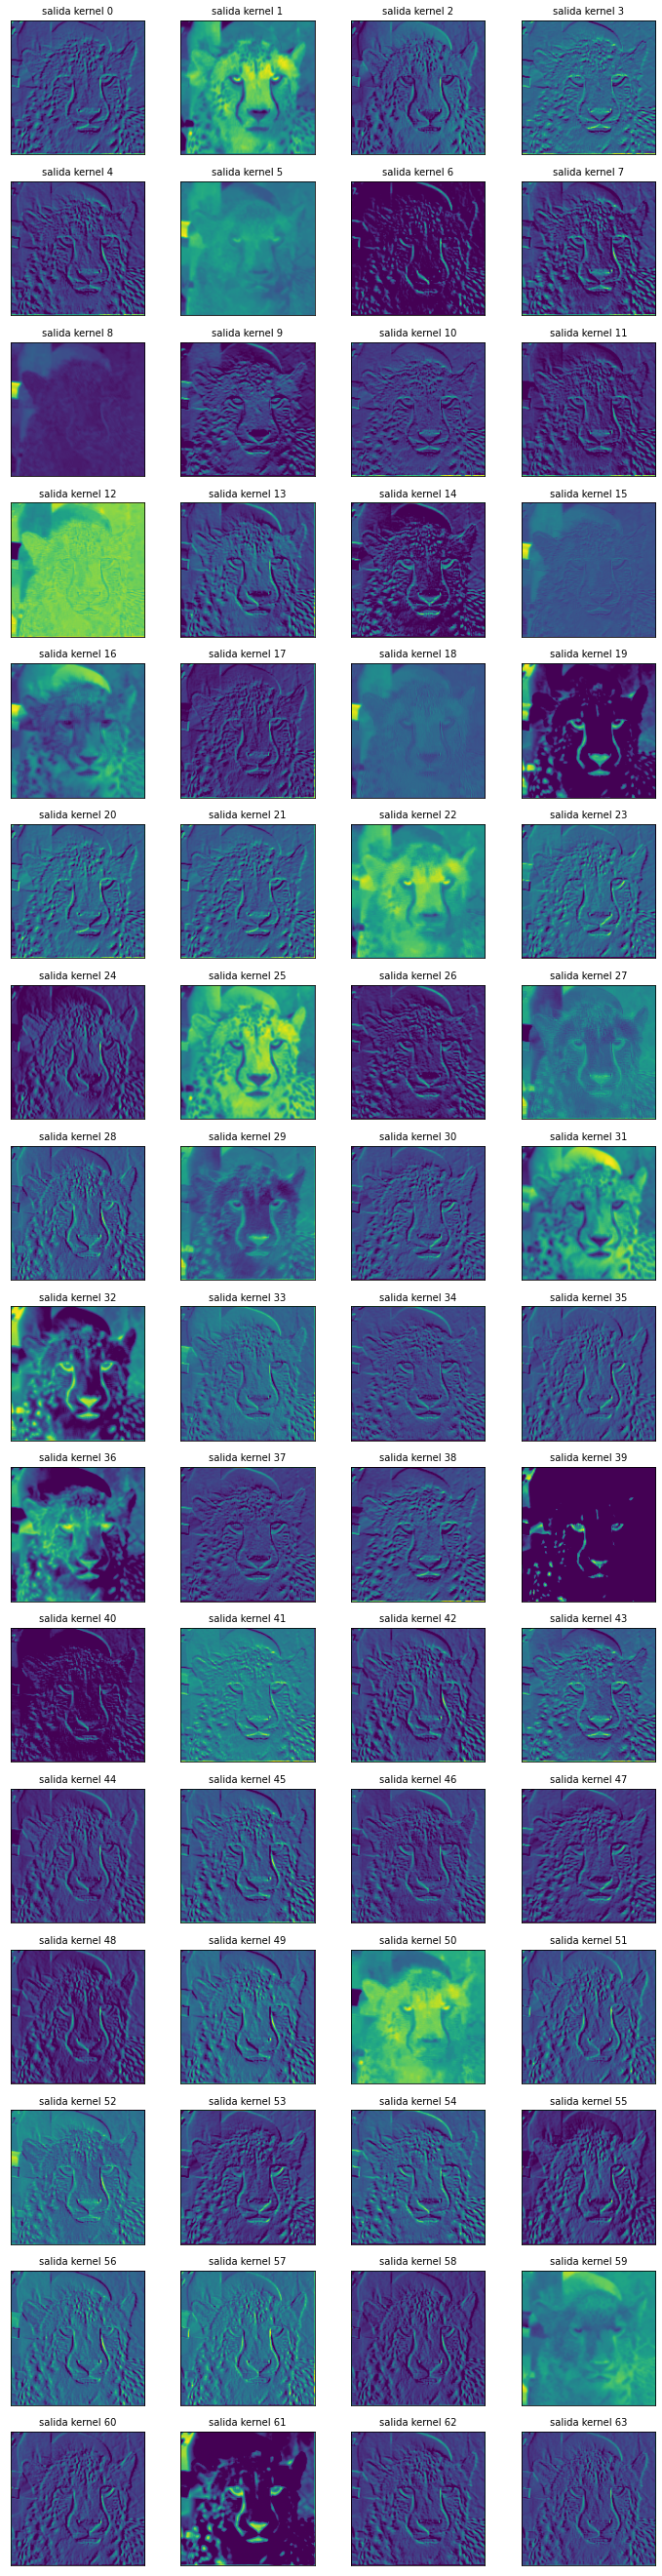

In [ ]:
#Se toma la imagen 10 del test
ejemplo = 10

imagen = X_te[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

### **Visualización de las salidas de varias capas**

In [ ]:
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in conv_base.layers[:6]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=conv_base.input, outputs=layer_outputs)

activations = activation_model.predict(X_te[ejemplo:(ejemplo+1)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


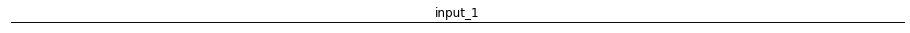

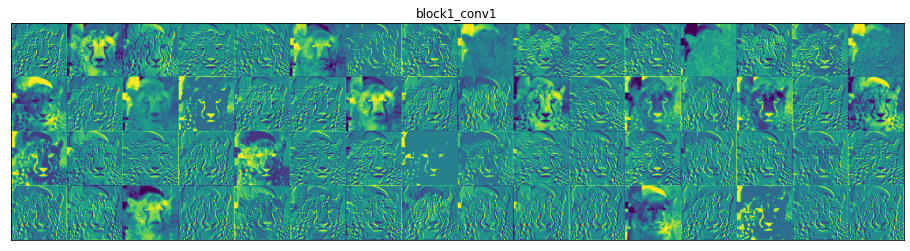

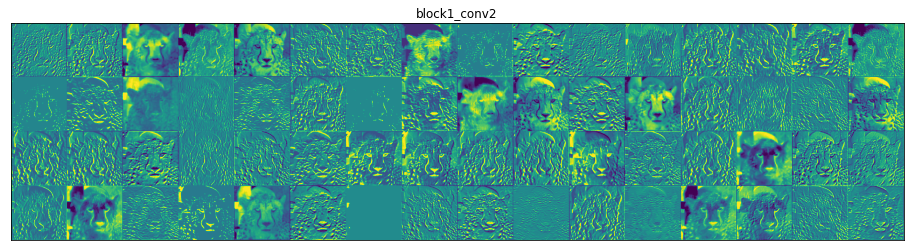

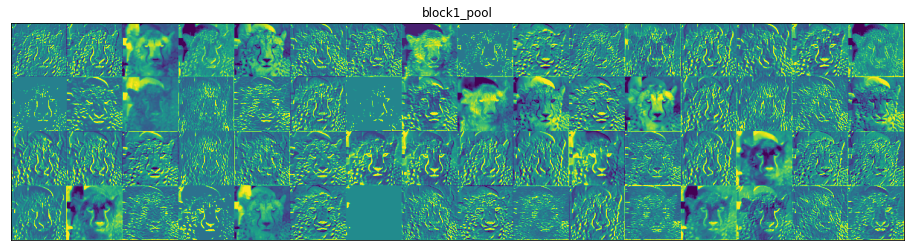

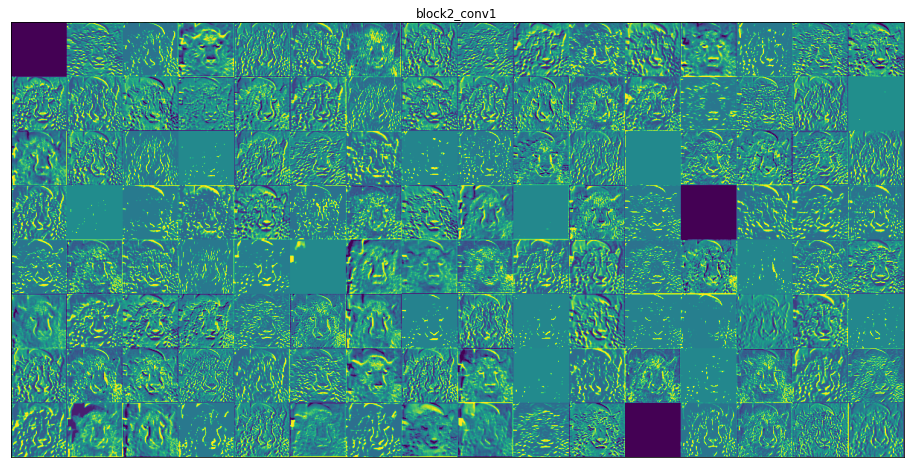

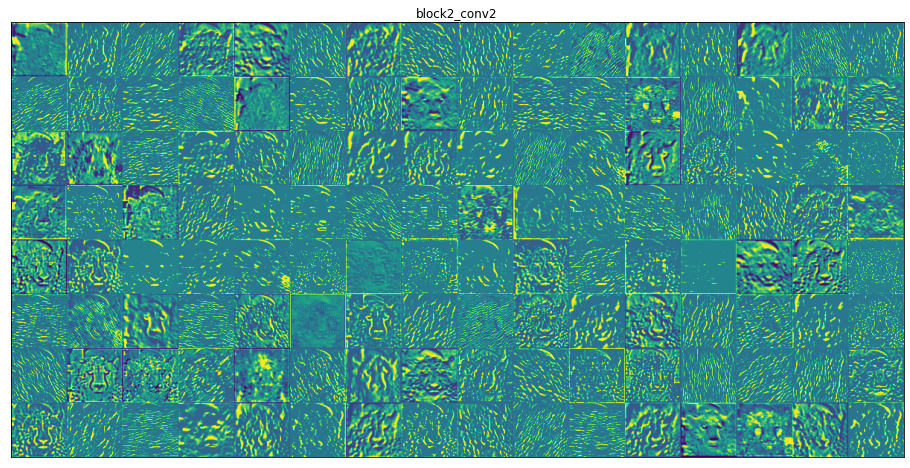

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in conv_base.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0] + 0.001))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### **Ahora analizamos las equivocaciones de la CNN en test cuando intentamos detectar gatos**



- clase 0: cat(gato)
- clase 1: dog(perro) 
- clase 2: wild(animal salvaje)

In [ ]:
def listadoError(lc,li):
  le = zip(lc,li)
  return le

In [ ]:
def errorPrediccion(clase, listado):
  lc = []
  li = []  
  for i in listado:
      img = X_te[i].copy()
      prd= model.predict(np.expand_dims(img, axis=0))
      c = np.argmax(prd)
      if (c != clase):
        #print(str(c), ' ---->', str(i))
        lc.append(c)
        li.append(i)
        
  la = tuple(listadoError(lc, li))
  la = sorted(la)
  arr = np.array(la)
  for i in arr:
    print('Indice de Foto en el dataset: ', i[1])    
    z= i[1]    
    show_image(z)

**Gatos que la red está segura que son Perros o Animales Salvajes**




Indice de Foto en el dataset:  28


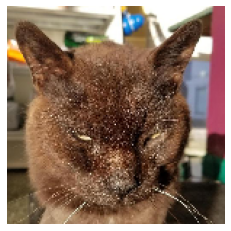

Probabilidad gato : 43.6%
Probabilidad perro: 56.0%
Probabilidad salvaje: 0.4%


Indice de Foto en el dataset:  623


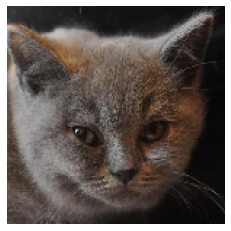

Probabilidad gato : 11.6%
Probabilidad perro: 0.0%
Probabilidad salvaje: 88.4%


Indice de Foto en el dataset:  1559


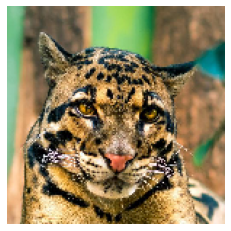

Probabilidad gato : 0.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 100.0%




In [ ]:
errorPrediccion(0, ind_cat)

**Perros que la red está segura que son Gatos o Animales Salvajes**

Indice de Foto en el dataset:  1081


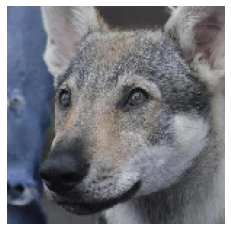

Probabilidad gato : 0.0%
Probabilidad perro: 42.8%
Probabilidad salvaje: 57.2%


Indice de Foto en el dataset:  1542


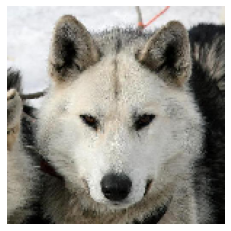

Probabilidad gato : 0.0%
Probabilidad perro: 47.4%
Probabilidad salvaje: 52.6%




In [ ]:
errorPrediccion(1, ind_dog)

**Animales Salvajes que la red está segura que son Gatos o Perros**

Indice de Foto en el dataset:  927


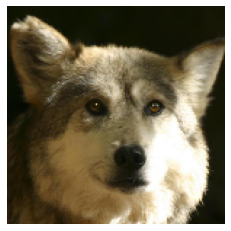

Probabilidad gato : 0.0%
Probabilidad perro: 99.9%
Probabilidad salvaje: 0.1%


Indice de Foto en el dataset:  1171


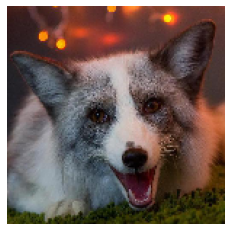

Probabilidad gato : 0.0%
Probabilidad perro: 100.0%
Probabilidad salvaje: 0.0%




In [ ]:
errorPrediccion(2,ind_wild)